# Modelagem e arquitetura CNN

## Modelo de canal único Raw RGB pré treinado RESNET50 + IMAGENET (Top layers off)

### Conteúdo

- Ingestão
- Pré processamento
- Modelagem da rede
- Treinamento
- Teste
- Validação
- Resultados

### Importações e parâmetros

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

videos_table_path = 'manual_frame_classification.csv'
videos_table_path_validation = 'manual_frame_validation.csv'
max_positive_cases = 5000
max_validation_cases = 10000
preprocess_training_test = False
preprocess_validation = True

### Ingestão

In [2]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path):
    img = tf.io.read_file(file_path, )
    img = decode_img(img)
    return img

def process_label(label):
    return label == 'POS'

def process_dataframe(dataframe):
    xs = []
    ys = []
    with tf.device('/cpu:0'):
        for i,row in dataframe.iterrows():
            path = row['path']
            label = row['violence']
            xs.append(process_path(path))
            ys.append(process_label(label))
        return tf.data.Dataset.from_tensor_slices((xs,ys))

In [14]:
frames_df = pd.read_csv(videos_table_path, sep=';', index_col=0)

c:\users\red\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
frames_df = frames_df[frames_df['load'] == 'X']
pos_len = len(frames_df[frames_df['violence'] == 'POS'])
neg_len = len(frames_df[frames_df['violence'] == 'NEG'])
ratio = 

In [46]:
ratio = pos_len/(pos_len + neg_len)
tot = 460920
n_pos = int(tot * ratio)
n_neg = tot - n_pos

36.90058777164734

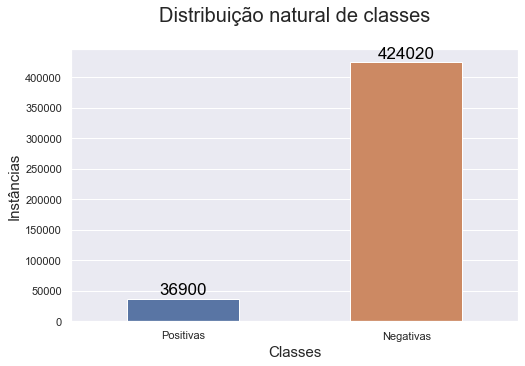

In [57]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(8,5)})
ax = sns.barplot(x=['Positivas','Negativas'], y=[n_pos, n_neg])
ax.set_title('Distribuição natural de classes\n', fontsize=20)
ax.set_xlabel('Classes', fontsize=15)
ax.set_ylabel('Instâncias', fontsize=15)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .5)
ax.text(0,45000, n_pos, color='black', ha="center", fontsize=17)
ax.text(1,430000, n_neg, color='black', ha="center", fontsize=17)
f = ax.get_figure()
f.savefig('class_dist.jpg')

In [38]:
ax.text?

Signature: ax.text(x, y, s, fontdict=None, withdash=<deprecated parameter>, **kwargs)
Docstring:
Add text to the axes.

Add the text *s* to the axes at location *x*, *y* in data coordinates.

Parameters
----------
x, y : scalars
    The position to place the text. By default, this is in data
    coordinates. The coordinate system can be changed using the
    *transform* parameter.

s : str
    The text.

fontdict : dictionary, optional, default: None
    A dictionary to override the default text properties. If fontdict
    is None, the defaults are determined by your rc parameters.

withdash : boolean, optional, default: False
    Creates a `~matplotlib.text.TextWithDash` instance instead of a
    `~matplotlib.text.Text` instance.

Returns
-------
text : `.Text`
    The created `.Text` instance.

Other Parameters
----------------
**kwargs : `~matplotlib.text.Text` properties.
    Other miscellaneous text parameters.

Examples
--------
Individual keyword arguments can be used to overrid

In [3]:
#IMPORT
frames_df = pd.read_csv(videos_table_path, sep=';', index_col=0)
video_list = frames_df[frames_df['load'] == 'X']['video'].unique()

#SEGREGATE
msk = np.random.rand(len(video_list)) < 0.9
train_test_videos = video_list[msk]
validation_videos =  video_list[~msk]
train_test_df = frames_df.loc[frames_df['video'].isin(train_test_videos)]
validation_df = frames_df.loc[frames_df['video'].isin(validation_videos)]

neg_df = train_test_df[train_test_df['violence'] == 'NEG'][['path','violence']]
pos_df = train_test_df[train_test_df['violence'] == 'POS'][['path','violence']]
neg_len = len(neg_df)
pos_len = len(pos_df)

#SHUFFLE
neg_df = neg_df.sample(frac=1).reset_index(drop=True)
pos_df = pos_df.sample(frac=1).reset_index(drop=True)
validation_df = validation_df.sample(frac=1).reset_index(drop=True)

#RESIZE
train_test_size = min([len(pos_df),max_positive_cases])
train_size = int(0.7*train_test_size)
test_size = train_test_size - train_size

pos_train_df = pos_df.head(train_size)
pos_test_df = pos_df.tail(test_size)

neg_train_df = neg_df.head(train_size)
neg_test_df = neg_df.tail(int(test_size*(neg_len/pos_len)))
                          
#MERGE
merged_train_df = pd.concat([pos_train_df, neg_train_df], ignore_index=True)
merged_test_df = pd.concat([pos_test_df, neg_test_df], ignore_index=True)
train_length = len(merged_train_df)
test_length = len(merged_test_df)
validation_length = len(validation_df)

print('Train dataset cases :' + str(train_length))
print('Test dataset cases :' + str(test_length))
print('Validation dataset cases :' + str(validation_length))

c:\users\red\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Train dataset cases :7000
Test dataset cases :17860
Validation dataset cases :38580


### Pré processamento

### Observações

Dataset claramente tendencioso (biased), será necessário tratar o desbalanceamento na fase de préprocessamento a fim de manter uma RN bem treinada.

#### Tarefas
- Separação do dataset em:
    - Dataset de treinamento (70%)
    - Dataset de teste (30%)

    
OBS: Todos os datasets devem estar balanceados! Portanto a medida balizadora será o gargalo atual: número de casos positivos. 

In [4]:
validation_df = pd.read_csv('validation_shuffled_df_mobilenet.csv', sep=';')
validation_length = len(validation_df)

In [5]:
#train_ds = None
#test_ds = None
#validation_ds = None

#RESHUFLE
if preprocess_training_test:
    shuffled_train_df = merged_train_df.sample(frac=1).reset_index(drop=True)
    shuffled_test_df = merged_test_df.sample(frac=2*test_size/test_length).reset_index(drop=True)

if preprocess_validation:
    validation_shuffled_df = validation_df.sample(frac=min(1,max_validation_cases/validation_length)).reset_index(drop=True)
    validation_length = len(validation_shuffled_df)

#PROCESS
if preprocess_training_test:
    train_ds = process_dataframe(shuffled_train_df)
    test_ds = process_dataframe(shuffled_train_df)
if preprocess_validation:
    validation_ds = process_dataframe(validation_shuffled_df)

print('Train DataFrame size: ' + str(int(train_length)))
print('Test DataFrame size: ' + str(int(test_length*2*test_size/test_length)))
print('Validation DataFrame size: ' + str(int(validation_length)))

### Clear unused data
frames_df = None
neg_df = None
pos_df = None
#merged_df = None
shuffled_df = None
complete_dataset = None

Train DataFrame size: 7000
Test DataFrame size: 3000
Validation DataFrame size: 10000


In [14]:
validation_df.to_csv('validation_shuffled_df_mobilenet.csv', sep=';')

In [6]:
train_batches = train_ds.shuffle(100).batch(50)

### Ponto de execução para treinamento

Caso queira seguir com a criação do modelo executar os blocos a seguir

In [6]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([50, 224, 224, 3])

### Modelagem da CNN

In [7]:
# Create the base model from the pre-trained model ResNet50
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

model = tf.keras.models.Sequential()
for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False


prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

model.add( tf.keras.layers.GlobalAveragePooling2D())
#model.add( tf.keras.layers.Reshape(target_shape=(1, 1, 1024)))
#model.add( tf.keras.layers.Dropout(0.001))
#model.add( tf.keras.layers.Conv2D(1000, (1,1), padding='same'))
#model.add( tf.keras.layers.Reshape(target_shape=(1000,)))
model.add(prediction_layer)
#model.build((None, IMG_SIZE, IMG_SIZE, 3))
#model.summary()

### Salvar modelo

In [8]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]) #

In [9]:
model.save('cnn_mobilenet_pretrainned_raw_rgb_v1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cnn_mobilenet_pretrainned_raw_rgb_v1\assets


### Carregar modelo

- OBS : Lembrar de ligar GPU

In [6]:
model = tf.keras.models.load_model('cnn_mobilenet_pretrainned_raw_rgb_v1')

In [10]:
history = model.fit_generator(train_batches, epochs=100)#, callbacks=[ tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)])

Instructions for updating:
Please use Model.fit, which supports generators.
Train for 140 steps
Epoch 1/100
140/140 [==============================] - 16s 115ms/step - loss: 0.6919 - accuracy: 0.5337 - precision: 0.6079 - recall: 0.1900
Epoch 2/100
140/140 [==============================] - 13s 92ms/step - loss: 0.6654 - accuracy: 0.6104 - precision: 0.8498 - recall: 0.2683
Epoch 3/100
140/140 [==============================] - 13s 90ms/step - loss: 0.6466 - accuracy: 0.6909 - precision: 0.8512 - recall: 0.4626
Epoch 4/100
140/140 [==============================] - 13s 90ms/step - loss: 0.6343 - accuracy: 0.7313 - precision: 0.8577 - recall: 0.5546
Epoch 5/100
140/140 [==============================] - 13s 90ms/step - loss: 0.6252 - accuracy: 0.7586 - precision: 0.8661 - recall: 0.6117
Epoch 6/100
140/140 [==============================] - 13s 90ms/step - loss: 0.6190 - accuracy: 0.7704 - precision: 0.8702 - recall: 0.6357
Epoch 7/100
140/140 [==============================] - 13s 91ms

In [4]:
import numpy as np
np.mean([8814,
8703,
8791,
8677,
8857])

8768.4

## Lr = 0.0001
loss: 0.5588 - accuracy: 0.8999 - precision: 0.9152 - recall: 0.8814 (09/07/20) - 1
loss: 0.5582 - accuracy: 0.9013 - precision: 0.9278 - recall: 0.8703 (09/07/20) - 2
loss: 0.5590 - accuracy: 0.9006 - precision: 0.9185 - recall: 0.8791 (09/07/20) - 3
loss: 0.5597 - accuracy: 0.8974 - precision: 0.9225 - recall: 0.8677 (09/07/20) - 4
loss: 0.5549 - accuracy: 0.9103 - precision: 0.9315 - recall: 0.8857 (09/07/20) - 5


13s/época

### Salvar modelo

In [11]:
model.save('cnn_mobilenet_pretrainned_raw_rgb_v1')

INFO:tensorflow:Assets written to: cnn_mobilenet_pretrainned_raw_rgb_v1\assets


In [12]:
import pickle
with open('trainHistoryDictMobileNet-5.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

### Fine tunning

# Avaliação do modelo
## Dataset de teste

In [13]:
#test_batch = test_ds.batch(150)
#with tf.device('/cpu:0'):
features = np.array([list(x[0].numpy()) for x in list(test_ds)])
labels = np.array([x[1].numpy() for x in list(test_ds)])
test_loss, test_acc, test_prec, test_rec = model.evaluate(x=features, y=labels, verbose=0)

print('\nTest accuracy:', test_acc)
print('\nTest precision:', test_prec)
print('\nTest recall:', test_rec)


Test accuracy: 0.8207143

Test precision: 0.8528764

Test recall: 0.77514285


In [6]:
#test_batch = test_ds.batch(150)
#with tf.device('/cpu:0'):
features = np.array([list(x[0].numpy()) for x in list(test_ds)])
labels = np.array([x[1].numpy() for x in list(test_ds)])
import time
start = time.time()
test_loss, test_acc, test_prec, test_rec = model.evaluate(x=features, y=labels, verbose=0)
end = time.time()
interval = (end - start)


print('\nTest accuracy:', test_acc)
print('\nTest precision:', test_prec)
print('\nTest recall:', test_rec)
print(str(interval) + 'segs')


Test accuracy: 0.79957145

Test precision: 0.84546953

Test recall: 0.73314285
13.201464414596558segs


## Teste

Lr 0.0001

Test accuracy: 0.8435714 Test precision: 0.81905013 Test recall: 0.882      (09/07/20) - 1
Test accuracy: 0.8352857 Test precision: 0.80268246 Test recall: 0.8891429  (09/07/20) - 2
Test accuracy: 0.8318571 Test precision: 0.80036205 Test recall: 0.8842857  (09/07/20) -3
Test accuracy: 0.8322857 Test precision: 0.8146645 Test recall:  0.8602857  (09/07/20) -4
Test accuracy: 0.8207143 Test precision: 0.8528764 Test recall:  0.77514285 (09/07/20) -5

13.2 seg / 7000 instâncias

## Dataset de validação

In [11]:
import numpy as np
np.mean([
    52071,
49641,
79105,
6875 ,
66315,
52777
])

51130.666666666664

In [8]:
features = np.array([list(x[0].numpy()) for x in list(validation_ds)])
labels = np.array([x[1].numpy() for x in list(validation_ds)])

In [9]:
import time
start = time.time()
test_loss, test_acc, test_prec, test_rec = model.evaluate(x=features, y=labels, verbose=0)
end = time.time()
interval = (end - start)
print('\nValidation accuracy:', test_acc)
print('\nValidation precision:', test_prec)
print('\nValidation recall:', test_rec)
print(str(interval) + 'segs')


Validation accuracy: 0.8824

Validation precision: 0.20628184

Validation recall: 0.50206614
17.386228561401367segs


## Validação

Lr 0.0001

Validation accuracy: 0.8045    Validation precision:    0.30738524 Validation recall: 0.52071005 (09/07/20) - 1
Validation accuracy: 0.7232    Validation precision:    0.1252262  Validation recall: 0.4964132  (09/07/20) - 1
Validation accuracy: 0.8128    Validation precision:    0.32942128 Validation recall: 0.79105926 (09/07/20) - 2
Validation accuracy: 0.9273    Validation precision:    0.11354839 Validation recall: 0.6875     (09/07/20) - 3 
Validation accuracy: 0.4721212 Validation precision:    0.10299727 Validation recall: 0.6631579  (09/07/20) -4
Validation accuracy: 0.8818    Validation precision:    0.23514852 Validation recall: 0.5277778  (09/07/20) - 5

17.38 seg / 10000 instâncias

100 Épocas de treinamento (7000 instâncias de treinamento)

Test accuracy: 0.833

Test precision: 0.86501724

Test recall: 0.78914285


Dataset de validação (10000 instâncias de frames de vídeos aleatórios não utilizados no treinamento)

Validation accuracy: 0.8045

Validation precision: 0.30738524

Validation recall: 0.52071005

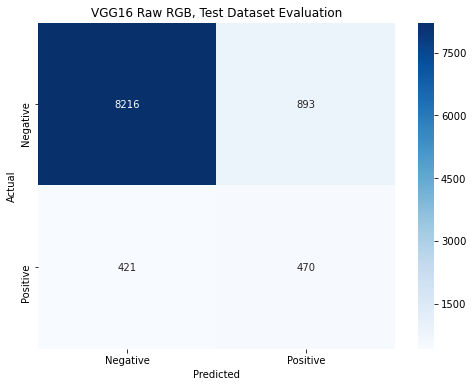

In [9]:
c_labels = [int(x) for x in labels]
predictions = model.predict_classes(features, batch_size=None)
pred = [x[0] for x in list(predictions)]
mat = tf.math.confusion_matrix(c_labels, pred)
df = pd.DataFrame(mat.numpy(), columns=['AP','AN'], index=['PP','PN'])
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df, cmap="Blues", annot=True, fmt="d", xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
ax.set_ylim([2,0])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('VGG16 Raw RGB, Test Dataset Evaluation')
plt.show()

In [18]:
mat

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2841,   99],
       [  75, 2854]])>

In [15]:
pred.count(0)

9828

In [11]:
tf.math.confusion_matrix?

Signature:
tf.math.confusion_matrix(
    labels,
    predictions,
    num_classes=None,
    weights=None,
    dtype=tf.int32,
    name=None,
)
Docstring:
Computes the confusion matrix from predictions and labels.

The matrix columns represent the prediction labels and the rows represent the
real labels. The confusion matrix is always a 2-D array of shape `[n, n]`,
where `n` is the number of valid labels for a given classification task. Both
prediction and labels must be 1-D arrays of the same shape in order for this
function to work.

If `num_classes` is `None`, then `num_classes` will be set to one plus the
maximum value in either predictions or labels. Class labels are expected to
start at 0. For example, if `num_classes` is 3, then the possible labels
would be `[0, 1, 2]`.

If `weights` is not `None`, then each prediction contributes its
corresponding weight to the total value of the confusion matrix cell.

For example:

```python
  tf.math.confusion_matrix([1, 2, 4], [2, 2, 4]) ==>